In [1]:
VEHICLES_CSV_PATH = './vehicles.csv'
CAUSES_OF_DEATH_CSV_PATH = './causes_of_death.csv'
FRAMINGHAM_CSV_PATH = './framingham.csv'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import sem, t
from scipy import mean
sns.set()

In [21]:
auto_df = pd.read_csv(VEHICLES_CSV_PATH)
subsidiaries = {
    'General Motors': ['General Motors', 'Chevrolot', 'Cadillac', 'GMC'],
    'Ford': ['Ford', 'Lincoln'],
    'Chrysler': ['Chrylser', 'Dodge', 'Jeep', 'Ram'],
    'Toyota': ['Toyota', 'Daihatsu', 'Lexus', 'Subaru'],
    'Honda': ['Honda', 'Acura'],
}

In [4]:
makes = ['Chevrolet', 'Ford', 'Chrysler', 'Honda', 'Toyota']
fuel_types = ['Midgrade Gasoline', 'Regular Gasoline', 'Premium Gasoline']
prob1_df = auto_df.loc[auto_df['year'].isin(range(2000,2020)) & auto_df['fuelType1'].isin(fuel_types)]

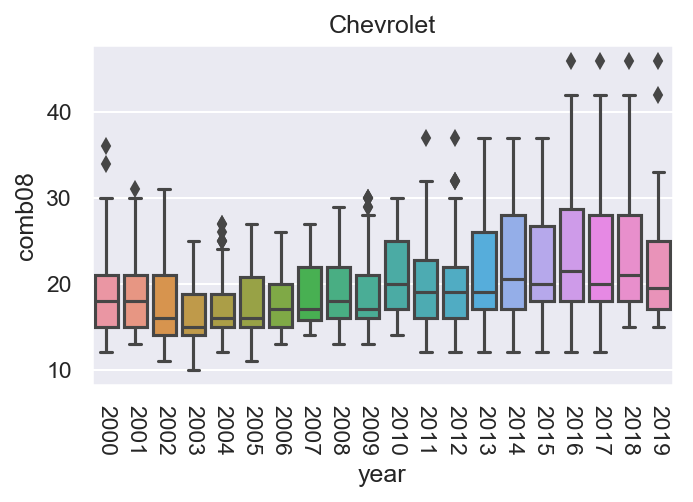

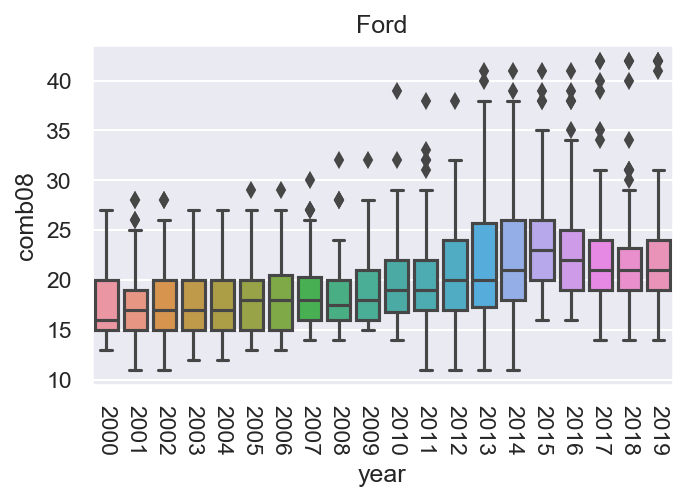

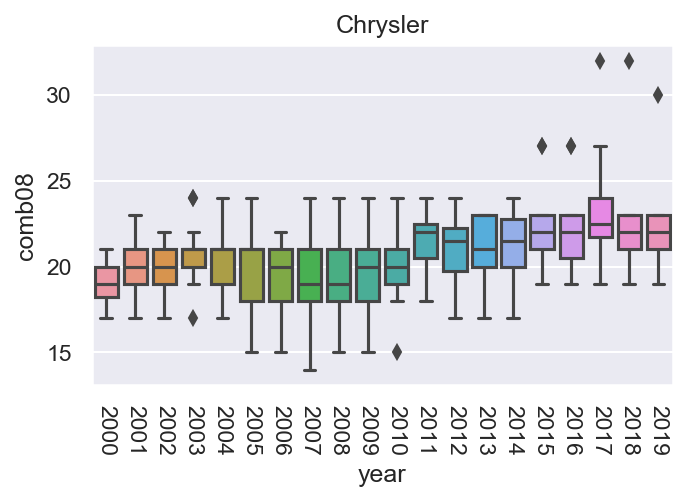

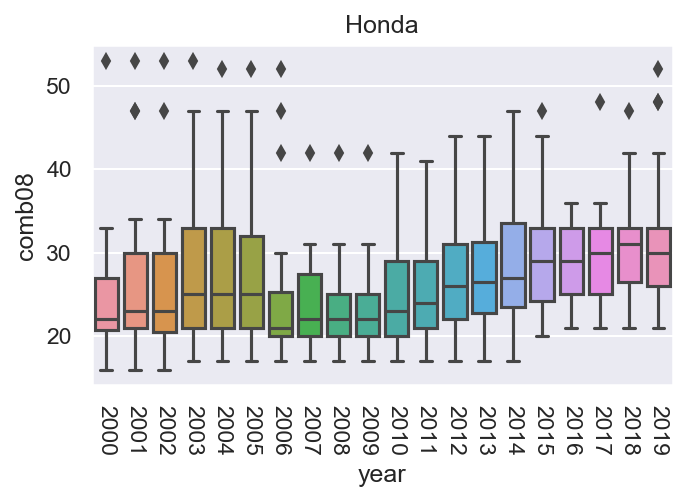

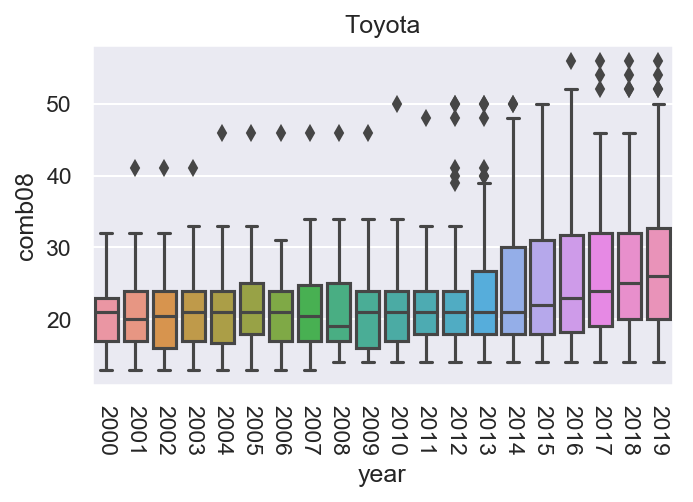

In [5]:
for make in makes:
    plt.figure(figsize=(5,3), dpi=150)
    sns.boxplot(x='year', y='comb08', data=prob1_df[prob1_df['make'] == make])
    plt.xticks(rotation=-90)
    plt.title(make)

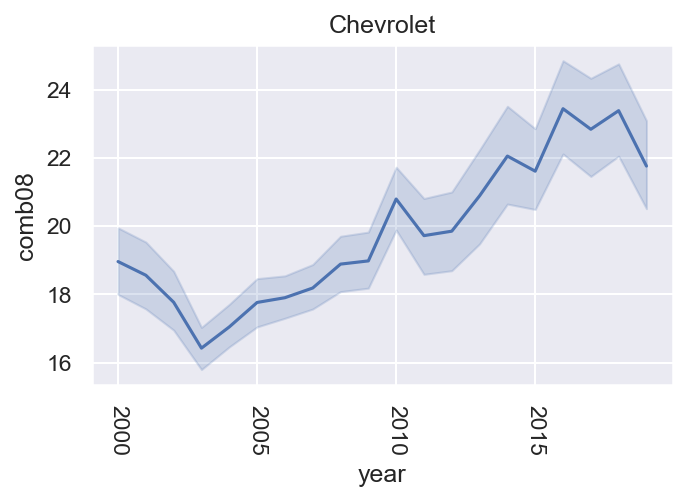

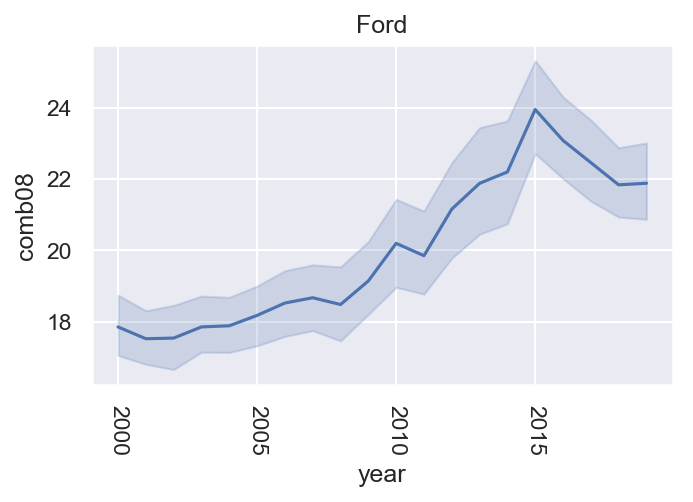

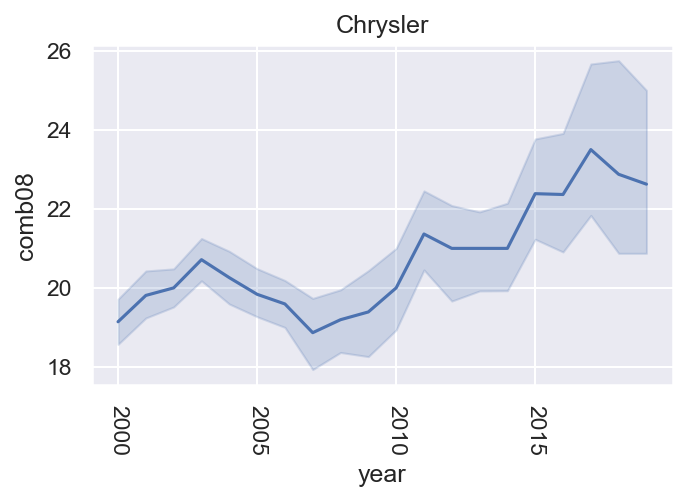

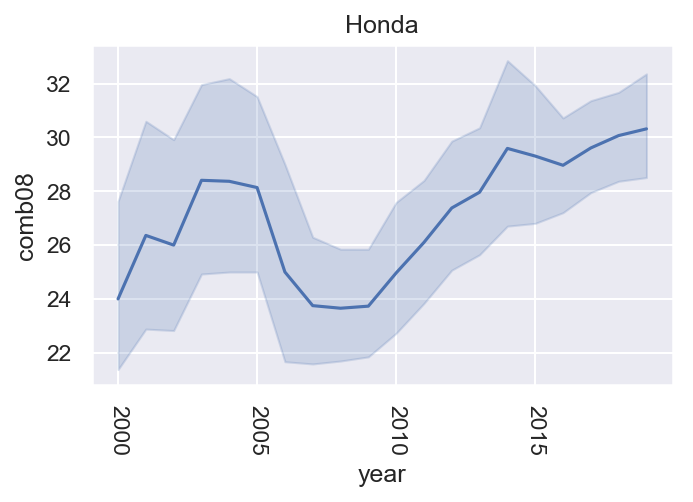

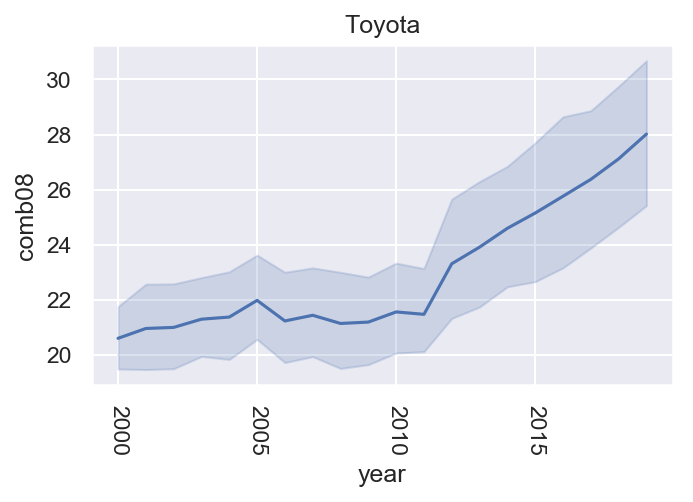

In [6]:
for make in makes:
    plt.figure(figsize=(5,3), dpi=150)
    sns.lineplot(x='year', y='comb08', data=prob1_df[prob1_df['make'] == make])
    plt.xticks(rotation=-90)
    plt.title(make)

In [7]:
prob1c_df = prob1_df.groupby(['make', 'year'])['comb08'].max()
prob1c_df2 = pd.DataFrame(prob1c_df.loc[makes]).reset_index()

(array([1997.5, 2000. , 2002.5, 2005. , 2007.5, 2010. , 2012.5, 2015. ,
        2017.5, 2020. ]), <a list of 10 Text xticklabel objects>)

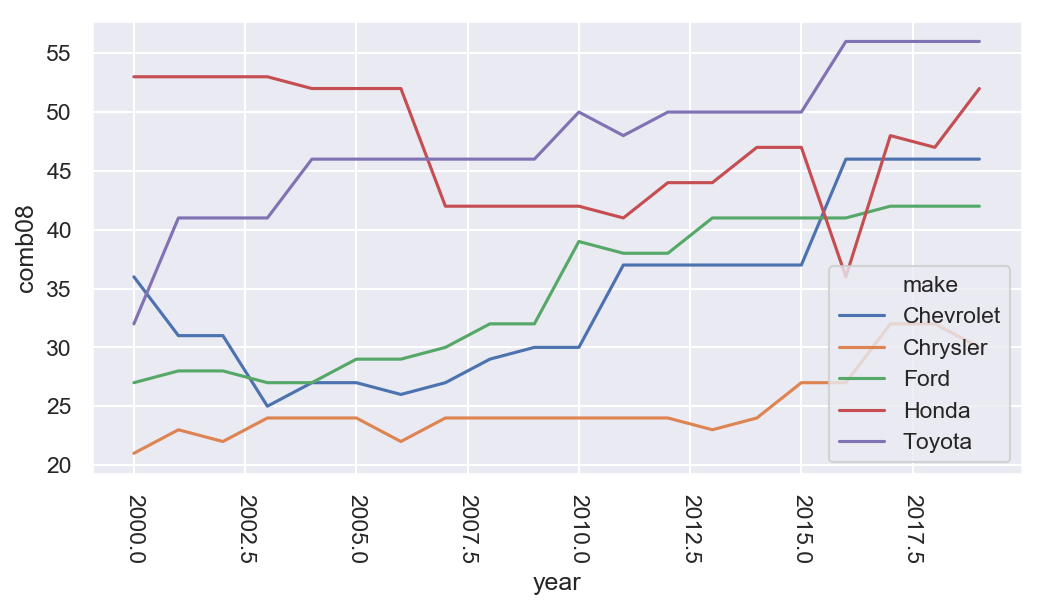

In [8]:
plt.figure(figsize=(8,4), dpi=150)
sns.lineplot(x='year', y='comb08', hue='make', data=prob1c_df2)
plt.xticks(rotation=-90)
# plt.title(make)

In [9]:
cod_df = pd.read_csv(CAUSES_OF_DEATH_CSV_PATH)
framingham_df = pd.read_csv(FRAMINGHAM_CSV_PATH)

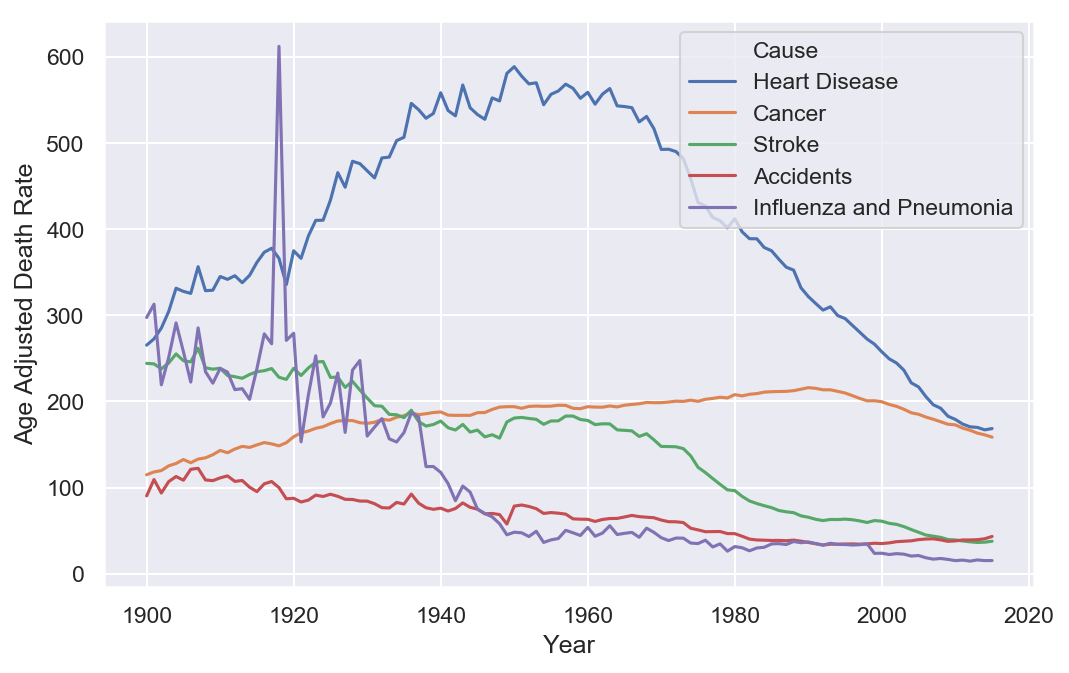

In [10]:
plt.figure(figsize=(8,5), dpi=150)
sns.lineplot(x="Year", y="Age Adjusted Death Rate", hue="Cause", data=cod_df)

## Percentage of people with Diabetes, as per Framingham

In [11]:
percentages = framingham_df['DIABETES'].value_counts(normalize=True) * 100
print("Percentage: {}%".format(percentages[1]))

Percentage: 2.732951587714732%


In [12]:
random_samples = []
sample_size = 5000
cdc_diabetes_prevalance = 0.93
probabilities = [cdc_diabetes_prevalance, 1 - cdc_diabetes_prevalance]
for i in range(200):
    random_samples.append(np.random.multinomial(sample_size, probabilities))
random_samples_df = pd.DataFrame(random_samples)
random_samples_df.head()

,0,1
0,4628,372
1,4682,318
2,4635,365
3,4667,333
4,4670,330


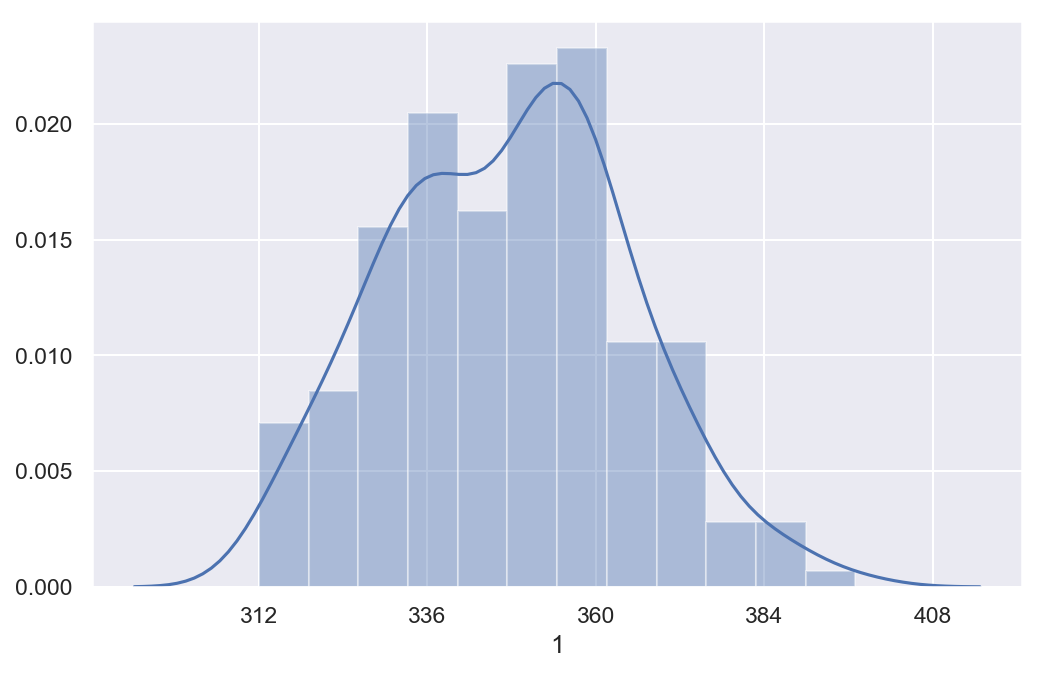

In [13]:
plt.figure(figsize=(8,5), dpi=150)
min_dist_value = min(random_samples_df[1])
max_dist_value = max(random_samples_df[1])

plt.xticks(range(min_dist_value - 24, max_dist_value + 24, 24))
sns.distplot(random_samples_df[1], bins=12)

In [14]:
def calculate_ci(data, confidence=0.95, print_results=False):
    confidence = 0.95
#     data = random_samples_df[1]

    num_samples = len(data)
    mean_value = mean(data)
    std_err = sem(data)
    deviation = std_err * t.ppf((1 + confidence) / 2, num_samples - 1)

    start = mean_value - deviation
    end = mean_value + deviation
    if print_results:
        print("{}% Confidence Interval: {} - {}".format(confidence*100, start, end))
    return (start, end)

In [15]:
_ = calculate_ci(random_samples_df[1], print_results=True)

95.0% Confidence Interval: 345.3540697600023 - 350.12593023999773


In [16]:
framingham_df.head()

,AGE,SYSBP,DIABP,TOTCHOL,CURSMOKE,DIABETES,GLUCOSE,DEATH,ANYCHD
0,39,106.0,70.0,195.0,0,0,77.0,0,1
1,46,121.0,81.0,250.0,0,0,76.0,0,0
2,48,127.5,80.0,245.0,1,0,70.0,0,0
3,61,150.0,95.0,225.0,1,0,103.0,1,0
4,46,130.0,84.0,285.0,1,0,85.0,0,0


In [17]:
framingham_df[['TOTCHOL', 'ANYCHD']].head()

,TOTCHOL,ANYCHD
0,195.0,1
1,250.0,0
2,245.0,0
3,225.0,0
4,285.0,0


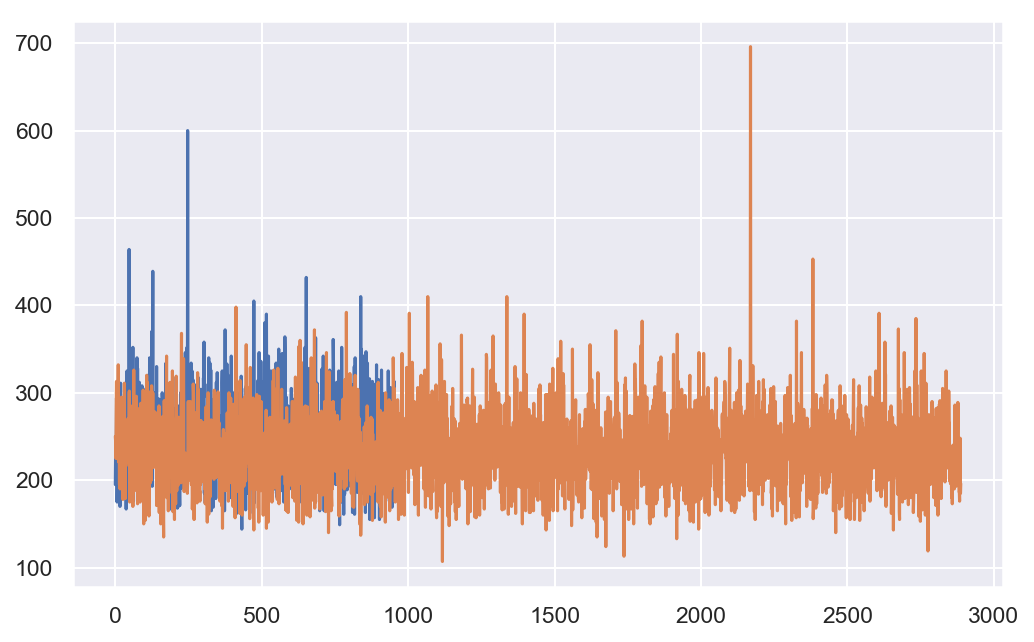

In [18]:
plt.figure(figsize=(8,5), dpi=150)
sns.lineplot(data=framingham_df.query('ANYCHD == 1')['TOTCHOL'].values)
sns.lineplot(data=framingham_df.query('ANYCHD == 0')['TOTCHOL'].values)

In [19]:
print("Cholesterol CI for people with heart disease:")
_ = calculate_ci(framingham_df.query('ANYCHD == 1')['TOTCHOL'].values, print_results=True)
print("Cholesterol CI for people without heart disease:")
_ = calculate_ci(framingham_df.query('ANYCHD == 0')['TOTCHOL'].values, print_results=True)

Cholesterol CI for people with heart disease:
95.0% Confidence Interval: 246.5403082552965 - 252.42405233170558
Cholesterol CI for people without heart disease:
95.0% Confidence Interval: 231.25983474347473 - 234.43268603214855
